In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps 
                                        
%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import pickle

In [3]:
import torch
import torchvision

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_printoptions(precision=4, sci_mode=False)

In [5]:
from moe_expectation_model import moe_expectation_model
from moe_pre_softmax_expectation_model import moe_pre_softmax_expectation_model
from moe_stochastic_model import moe_stochastic_model, moe_stochastic_loss
from moe_em_model import moe_em_model
from moe_models import cross_entropy_loss
from experts_gates import escort

device cpu
device cpu
device cpu
device cpu
device cpu


In [6]:
import data_generator
import datagen

device cpu


### Generate dataset for training

In [7]:
fig_path = 'figures/exps'
model_path = 'results/exps'

In [8]:
palette = ['tab:purple', 'tab:green', 'tab:orange','tab:blue', 'tab:brown','tab:cyan','y']

In [9]:
def plot_data(X, Y, y, num_classes, dataset, path):
    f, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
    sns.scatterplot(x=X[:,0],y=X[:,1],hue=y, palette=palette[0:num_classes], ax=ax[0])
    sns.scatterplot(x=Y[:,0],y=Y[:,1],hue=y, palette=palette[0:num_classes],ax=ax[1])
    ax[0].set_title("2D 3 classes Generated X Data")
    ax[1].set_title("2D 3 classes Generated Y Data")
    plt.ylabel('Dim 2')
    plt.xlabel('Dim 1')
    plt.savefig(os.path.join(path, dataset+'_'+str(num_classes)+'.png'))

In [10]:
dataset = 'barber_regression_em_linear_expert_gate'

In [11]:
num_classes = 2
batchsize = 64

2561032137

Rotation Matrix R
[[0.5521157959271491, -0.8337674423289331],
 [0.8337674423289331, 0.5521157959271491]]

Scaling Matrix S
array([[0.55376421, 0.        ],
       [0.        , 0.05929159]])


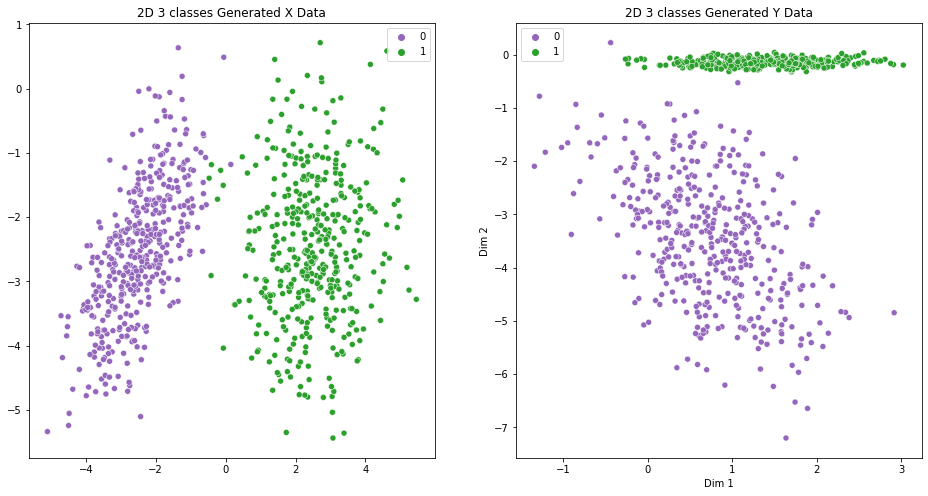

In [12]:
import math
random_state = np.random.randint(4058803790)
random_state = 2561032137
print(random_state)
X, y = make_classification(n_samples=1040, n_features=2, n_informative=2, n_redundant=0, n_classes=2, 
                           n_clusters_per_class=1, flip_y=0, class_sep=2.5, random_state=random_state)

x_train, x_test, y_train_o, y_test_o = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

theta = math.cos(np.random.randint(90))
R = [[math.cos(theta), -1*math.sin(theta)],[math.sin(theta), math.cos(theta)]]
print('\nRotation Matrix R')
pprint(R)
S = np.diag(np.diag(np.random.rand(2,2)))
print('\nScaling Matrix S')
pprint(S)

indices = np.where(y_train_o==0)
x_train_r = x_train[indices]
y_train_r = np.dot(R,x_train[indices].T).T
y_train_o_r = y_train_o[indices]
indices = np.where(y_train_o==1)
x_train_s = x_train[indices]
y_train_s = np.dot(S,x_train[indices].T).T
y_train_o_s = y_train_o[indices]

x_train = np.vstack((x_train_r, x_train_s))
y_train = np.concatenate((y_train_r, y_train_s))
y_train_o = np.concatenate((y_train_o_r, y_train_o_s))

indices = np.where(y_test_o==0)
x_test_r = x_test[indices]
y_test_r = np.dot(R,x_test[indices].T).T
indices = np.where(y_test_o==1)
x_test_s = x_test[indices]
y_test_s = np.dot(S,x_test[indices].T).T

x_test = np.vstack((x_test_r, x_test_s))
y_test = np.concatenate((y_test_r, y_test_s))

# Create trainloader

trainset = torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32), 
                                          torch.tensor(y_train, dtype=torch.float32))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=1, pin_memory=True)
testset = torch.utils.data.TensorDataset(torch.tensor(x_test, dtype=torch.float32),
                                         torch.tensor(y_test, dtype=torch.float32))
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                         shuffle=True, num_workers=1, pin_memory=True)
plot_data(x_train, y_train, y_train_o, num_classes, dataset, fig_path)

In [13]:
trainset

### Networks and callbacks

In [14]:
#Expert network
class expert_layers(nn.Module):
    def __init__(self, output):
        super(expert_layers, self).__init__()
        linear = nn.Linear(2,output)
        # Set bias to 0 as we want to learn only the weights
        linear.bias.data.fill_(0.0)
        self.model = nn.Sequential(OrderedDict({'linear':linear}))     
        
    def forward(self, input):
        return self.model(input)


In [15]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes))
    return nn.ModuleList(models)

In [16]:
#Gate network (Similar to the expert layer)
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        self.model = nn.Sequential(OrderedDict({
                    'linear':nn.Linear(2,num_experts)
                    })
                )
        
    def forward(self, input_aug, T=1.0):
        t = self.model(input_aug)
        return F.softmax(t/T, dim=1)

### Mixture of experts model

In [17]:
# compute
def accuracy(out, yb, mean=True):
    return torch.mean(torch.sum(torch.square(out-yb)))

In [18]:
total_experts = 2

In [19]:
num_epochs = 30

In [20]:
# experiment with models with different number of experts
w_importance=0.0
w_ortho = 0.0
w_ideal_gate = 0.0

augment = False
attention = False
T_max = 1
T_decay = 0
T_decay_start = 0

task = 'regression'
fixed_bias = True

def generate_plot_file(dataset, specific):
    plot_file = dataset
    if T_decay > 0:
        plot_file += '_Tdecay_'+str(T_decay)
    if T_decay_start > 0:
        plot_file += '_Tdecaystart_'+str(T_decay_start)
    if w_importance > 0:
        plot_file += '_importance_'+str(w_importance)
    if w_ortho > 0:
        plot_file += '_ortho_'+str(w_ortho)
    if augment:
        plot_file += '_augment'
    if attention:
        plot_file += '_attention'
    plot_file += '_'+specific
    
    return plot_file


In [21]:
models = {'moe_em_model':{'model':moe_em_model,'loss':nn.MSELoss,'experts':{}},
        'moe_expectation_model':{'model':moe_expectation_model,'loss':nn.MSELoss,'experts':{}}, 
          'moe_stochastic_model':{'model':moe_stochastic_model, 'loss':moe_stochastic_loss(nn.MSELoss),'experts':{}}
         }

for key, val in models.items():
    print('Model:', key)
    for num_experts in range(total_experts, total_experts+1):
        print('Number of experts ', num_experts)
        expert_models = experts(num_experts, num_classes)
        gate_model = gate_layers(num_experts)
        moe_model = val['model'](num_experts, num_classes, augment, attention, expert_models, gate_model, task)
        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))

        if fixed_bias:
            for i in range(num_experts):
                bias = False
                for param in moe_model.experts[i].parameters():
                    if not bias:
                        bias = True
                    else:
                        param.requires_grad = False

        optimizer_moe = optim.SGD(moe_model.parameters(),
                                  lr=0.1, momentum=0.9)
        optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                  lr=0.01, momentum=0.9)
        params = []
        for i, expert in enumerate(expert_models):
            params.append({'params':expert.parameters()})
        optimizer_experts = optim.RMSprop(params, lr=0.01, momentum=0.9)

        hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe, optimizer_gate, optimizer_experts,  
                               w_importance, w_ortho, w_ideal_gate, accuracy=accuracy, epochs=num_epochs)
        val['experts'][num_experts] = {'model':moe_model, 'history':hist}
    plot_file = generate_plot_file(dataset, str(num_classes)+'_'+str(num_experts)+'_model.pt')
    print('model file:', plot_file)
    torch.save(models,open(os.path.join(model_path, plot_file),'wb'))    


Model: moe_em_model
Number of experts  2
model params: 18
2 0.0009538749999986607
3 0.0004657730000001692
4 0.7454368850000002
5 0.0007995750000002744
6 0.4957543829999995
7 0.005145344000000662
8 0.002249841999999447
5 0.06190569299999993
6 0.502339751000001
7 0.005370045999999462
8 0.0016787990000004527
5 0.06108394199999978
6 0.5001303640000003
7 0.004793525999998494
8 0.0016912740000005755
5 0.06323613200000011
6 0.5806002279999998
7 0.007110148000000649
8 0.0019990050000000537
5 0.08626856499999924
6 0.5849715470000003
7 0.007714177000000433
8 0.0020606240000002884
5 0.08604698399999933
6 0.5317977000000003
7 0.005108625000000089
8 0.0018658009999992231
5 0.06090555100000117
6 0.5326997449999986
7 0.004981669000001077
8 0.001536943999999707
5 0.06172860100000044
6 0.499995685
7 0.004854441999999182
8 0.001510570000000655
5 0.06054020200000032
6 0.4965707989999988
7 0.005073775999999697
8 0.0016731710000001954
5 0.0759017790000005
6 0.582400977999999
7 0.0052882250000010345
8 0.001

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/peac004/opt/anaconda3/envs/pytorch1.6.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-e5272d07c673>", line 34, in <module>
    hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe, optimizer_gate, optimizer_experts,
  File "/Users/peac004/modular_learning_research/modular_deep_learning/pytorch/moe_em_model.py", line 182, in train
    for inputs, labels in new_batch:
  File "/Users/peac004/opt/anaconda3/envs/pytorch1.6.0/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 363, in __next__
    data = self._next_data()
  File "/Users/peac004/opt/anaconda3/envs/pytorch1.6.0/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 974, in _next_data
    idx, data = self._get_data()
  File "/Users/peac004/opt/anaconda3/envs/pytorch1.6.0/lib/python3.8/site-packages/torch/utils/data

TypeError: object of type 'NoneType' has no len()

In [ ]:
plot_file = generate_plot_file(dataset, str(num_classes)+'_'+str(total_experts)+'_model.pt')
print('model file:', plot_file)
models=torch.load(open(os.path.join(model_path, plot_file),'rb'))    


In [48]:
for m_key, m_val in models.items():
    print(m_key)
    moe_model = m_val['experts'][total_experts]['model']
    
    for i, expert in enumerate(moe_model.experts):
        bias = False
        for param in expert.parameters():
            if not bias:
                print('Expert ',i,' weights:\n', param)
                bias = True
    print('\n')



moe_em_model
Expert  0  weights:
 Parameter containing:
tensor([[ 0.6072,  0.7946],
        [-0.7946,  0.6072]], requires_grad=True)
Expert  1  weights:
 Parameter containing:
tensor([[     0.6582,      0.0000],
        [    -0.0000,      0.2836]], requires_grad=True)


moe_expectation_model
Expert  0  weights:
 Parameter containing:
tensor([[ 0.5954,  0.8161],
        [-0.7934,  0.6062]], requires_grad=True)
Expert  1  weights:
 Parameter containing:
tensor([[ 0.6510, -0.0060],
        [-0.0025,  0.2809]], requires_grad=True)


moe_stochastic_model
Expert  0  weights:
 Parameter containing:
tensor([[ 0.6217,  0.7767],
        [-0.7904,  0.6019]], requires_grad=True)
Expert  1  weights:
 Parameter containing:
tensor([[    0.6661,     0.0061],
        [    0.0001,     0.2833]], requires_grad=True)




In [24]:
pprint(torch.tensor(R))
pprint(torch.tensor(S))

tensor([[ 0.9081,  0.4188],
        [-0.4188,  0.9081]])
tensor([[0.0603, 0.0000],
        [0.0000, 0.9340]], dtype=torch.float64)


In [21]:
pickle.dump([R,S], open(os.path.join(model_path,dataset+'_r_s_v7.pkl'),'wb'))

In [24]:
pprint(pickle.load(open(os.path.join(model_path,dataset+'_r_s_v7.pkl'),'rb')))

[[[0.8575532158463934, -0.5143952585235492],
  [0.5143952585235492, 0.8575532158463934]],
 array([[0.09874845, 0.        ],
       [0.        , 0.74440496]])]


barber_regression_em_linear_expert_gate_2_2_model.pt
moe_em_model 



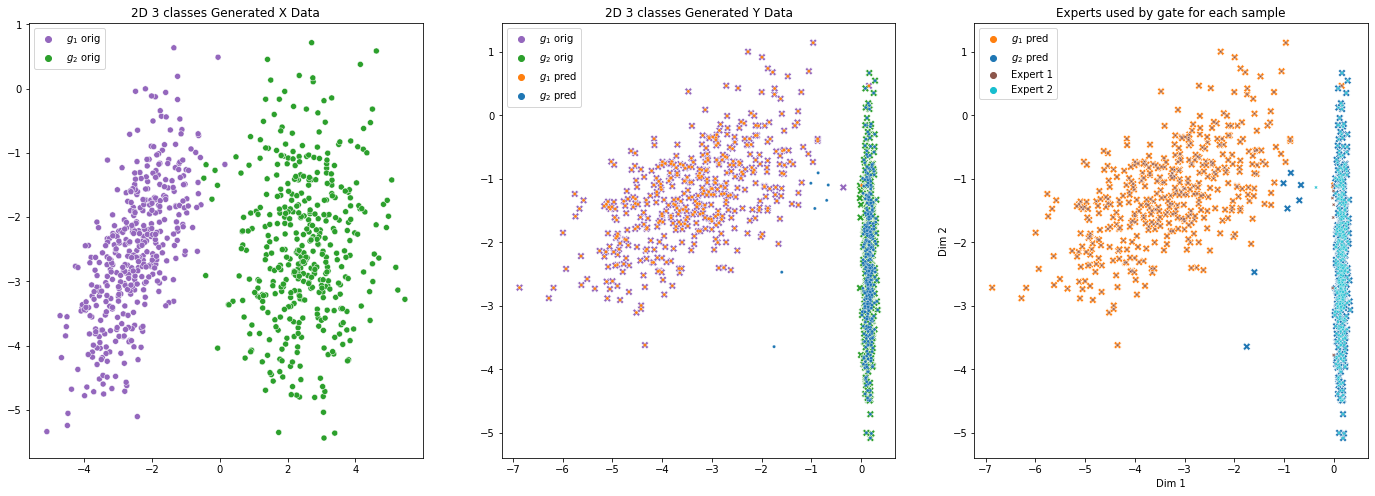

moe_expectation_model 



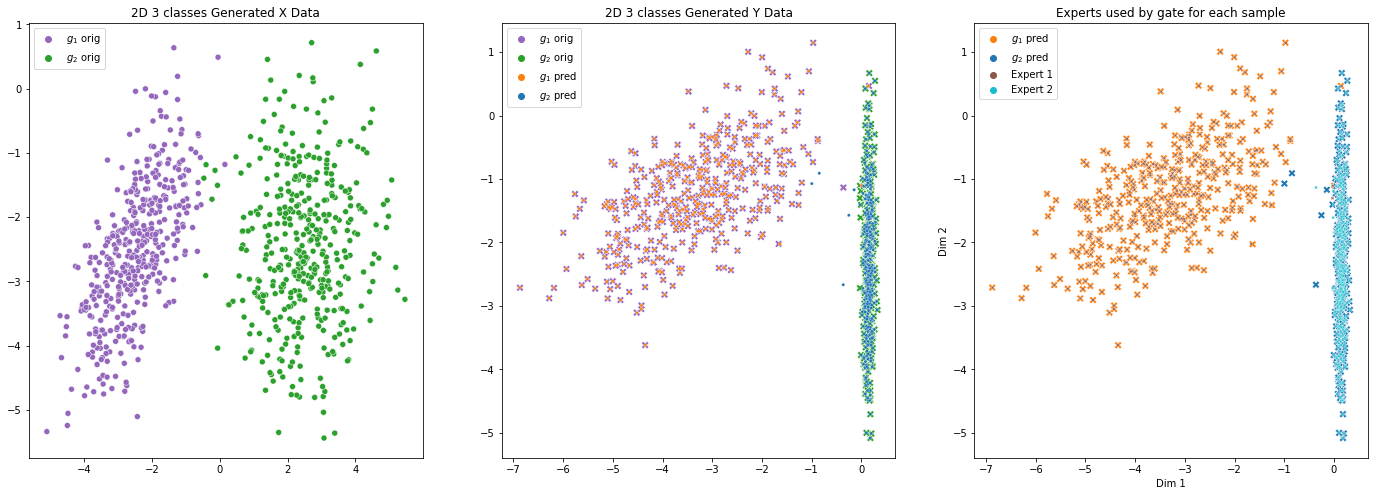

moe_stochastic_model 



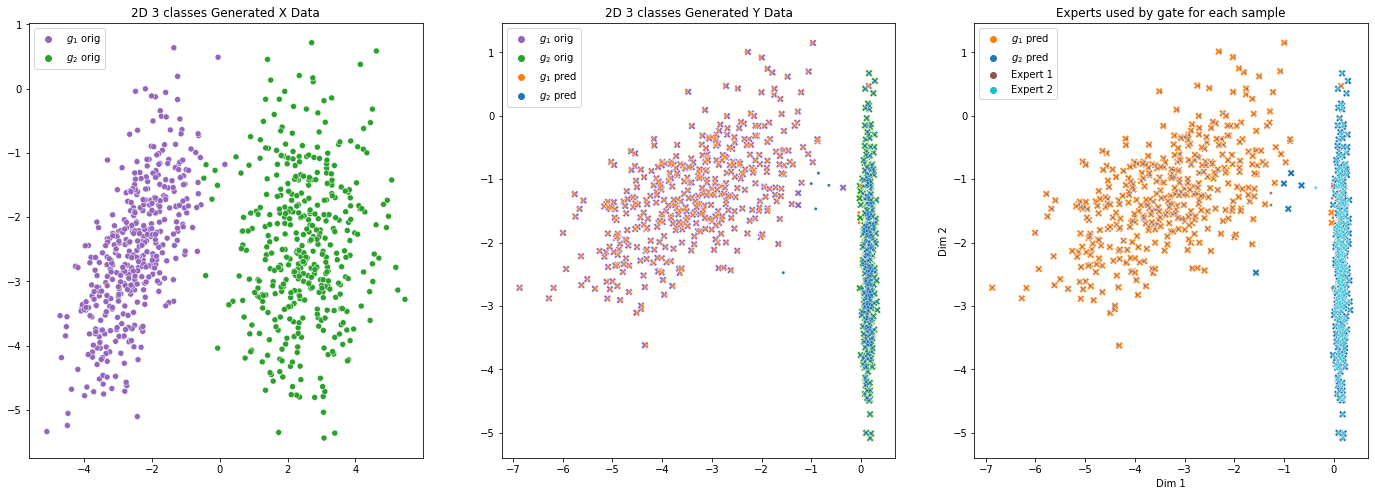

In [25]:
X = trainset[:][0]
Y = trainset[:][1]
plot_file = generate_plot_file(dataset, str(num_classes)+'_'+str(total_experts)+'_model.pt')
print(plot_file)
models = torch.load(os.path.join(model_path, plot_file))

for m_key, m_val in models.items():
    print(m_key,'\n')
    moe_model = m_val['experts'][total_experts]['model']

    c = [r'$g_1$ orig', r'$g_2$ orig']
    labels = [c[i] for i in y_train_o]

    c_pred = [r'$g_1$ pred', r'$g_2$ pred']
    labels_pred = [c_pred[i] for i in y_train_o]

    with torch.no_grad():
        y_pred = moe_model(X)

        f, ax = plt.subplots(nrows=1, ncols=3,figsize=(24,8))
        sns.scatterplot(x=X[:,0],y=X[:,1],hue=labels, palette=palette[0:num_classes],ax=ax[0])
        sns.scatterplot(x=Y[:,0],y=Y[:,1],hue=labels, palette=palette[0:num_classes],marker='X', s=60, ax=ax[1])
        sns.scatterplot(x=y_pred[:,0],y=y_pred[:,1],hue=labels_pred, palette=palette[num_classes:num_classes+2],s=10,ax=ax[1])
        ax[0].set_title("2D 3 classes Generated X Data")
        ax[1].set_title("2D 3 classes Generated Y Data")

        gate_outputs = moe_model.gate_outputs
        gate_experts = torch.argmax(gate_outputs, dim=1)

        c = ['Expert 1', 'Expert 2']
        labels = [c[i] for i in gate_experts]

        sns.scatterplot(x=y_pred[:,0],y=y_pred[:,1],hue=labels_pred, palette=palette[num_classes:num_classes+2],marker='X', s=60, ax=ax[2])
        sns.scatterplot(x=Y[:,0],y=Y[:,1],hue=labels, palette=palette[num_classes+2:num_classes+4],marker='X', s=10, ax=ax[2])

        ax[2].set_title('Experts used by gate for each sample')
        ax[2].set_ylabel('Dim 2')
        ax[2].set_xlabel('Dim 1')

        plt.savefig(os.path.join(fig_path, dataset+'_'+m_key+'_'+str(num_classes)+'.png'))
        plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (8,4)
for T in range(1, T_max+1):
    plot_file = generate_plot_file(dataset, str(num_classes)+'_'+str(total_experts)+'_model.pt')
    print('model: ', plot_file)
    models = torch.load(os.path.join(model_path, plot_file))


    for m_key, m_val in models.items():
        
        fig,ax = plt.subplots(4, 3, sharex=True, sharey=False, figsize=(30,40))

        for i in range(total_experts, total_experts+1):

            history = m_val['experts'][i]['history']
            legend_labels = ['E'+str(j) for j in range(1, i+1)]

            ax[0,0].plot(range(num_epochs), history['mean_gate_probability'], marker='o')            
            ax[0,0].set_title(m_key+'\n'+'Average gate probabilities for ' + str(i) + ' Experts with low T')
            ax[0,0].legend(legend_labels)
            ax[0,0].set_xlabel('Number of epochs')
            ax[0,0].set_xlim(0, num_epochs)
            ax[0,0].set_ylim(0, 1)
            ax[0,0].set_ylabel('Average Gate Probabilities')


            ax[0,1].plot(range(num_epochs), history['var_gate_probability'], marker='o')            
            ax[0,1].set_title(m_key+'\n'+'Variance gate probabilities for ' + str(i) + ' Experts with low T')
            ax[0,1].legend(legend_labels)
            ax[0,1].set_xlabel('Number of epochs')
            ax[0,1].set_xlim(0, num_epochs)
            ax[0,1].set_ylabel('Variance Gate Probabilities')

            ax[0,2].plot(range(num_epochs), history['mean_gate_log_probability'], marker='o')            
            ax[0,2].set_title(m_key+'\n'+'Average gate log probabilities for ' + str(i) + ' Experts with low T')
            ax[0,2].legend(legend_labels)
            ax[0,2].set_xlabel('Number of epochs')
            ax[0,2].set_xlim(0, num_epochs)
            ax[0,2].set_ylabel('Average Gate log Probabilities')

            ax[1,0].plot(range(num_epochs), 1-np.asarray(history['expert_sample_accuracy']), marker='o')

            ax[1,0].set_title(m_key+'\n'+'Gated training error for ' + str(i) + ' experts and low T')
            ax[1,0].legend(legend_labels)
            ax[1,0].set_xlabel('Number of epochs')
            ax[1,0].set_xlim(0, num_epochs)
            ax[1,0].set_ylabel('Error')

            ax[1,1].plot(range(num_epochs), 1-np.asarray(history['expert_accuracy']), marker='o')

            ax[1,1].set_title(m_key+'\n'+'Overall training error for ' + str(i) + ' experts')
            ax[1,1].legend(legend_labels)
            ax[1,1].set_xlabel('Number of epochs')
            ax[1,1].set_xlim(0, num_epochs)
            ax[1,1].set_ylabel('Error')

            ax[1,2].axis('off')

            ax[2,0].plot(range(len(history['expert_val_accuracy'])), 1-np.asarray(history['expert_val_accuracy']), marker='o')

            ax[2,0].set_title(m_key+'\n'+'Overall validation error for ' + str(i) + ' experts')
            ax[2,0].legend(legend_labels)
            ax[2,0].set_xlabel('Number of epochs')
            ax[2,0].set_xlim(0, num_epochs)
            ax[2,0].set_ylabel('Error')

            ax[2,1].plot(range(len(history['expert_sample_val_accuracy'])), 1-np.asarray(history['expert_sample_val_accuracy']), marker='o')
            ax[2,1].set_title(m_key+'\n'+'Gated validation error for ' + str(i) + ' experts')
            ax[2,1].legend(legend_labels)
            ax[2,1].set_xlabel('Number of epochs')
            ax[2,1].set_xlim(0, num_epochs)
            ax[2,1].set_ylabel('Error')

            ax[2,2].axis('off')

            ax[3,0].plot(range(num_epochs), history['expert_sample_loss'], marker='o')

            ax[3,0].set_title(m_key+'\n'+'Gated training loss for ' + str(i) + ' experts')
            ax[3,0].legend(legend_labels)
            ax[3,0].set_xlabel('Number of epochs')
            ax[3,0].set_xlim(0, num_epochs)
            ax[3,0].set_ylabel('loss')


            ax[3,1].plot(range(num_epochs), history['expert_loss'], marker='o')

            ax[3,1].set_title(m_key+'\n'+'Overall Training loss for ' + str(i) + ' Experts')
            ax[3,1].legend(legend_labels)
            ax[3,1].set_xlabel('Number of epochs')
            ax[3,1].set_xlim(0, num_epochs)
            ax[3,1].set_ylabel('loss')

            ax[3,2].axis('off')

            image_file = generate_plot_file(dataset+'_'+m_key,'T_'+str(T)+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
            plt.savefig(os.path.join(fig_path, 'dashboard_'+image_file))
            plt.show()


model:  barber_regression_linear_expert_gate_T_1_2_2_model.pt


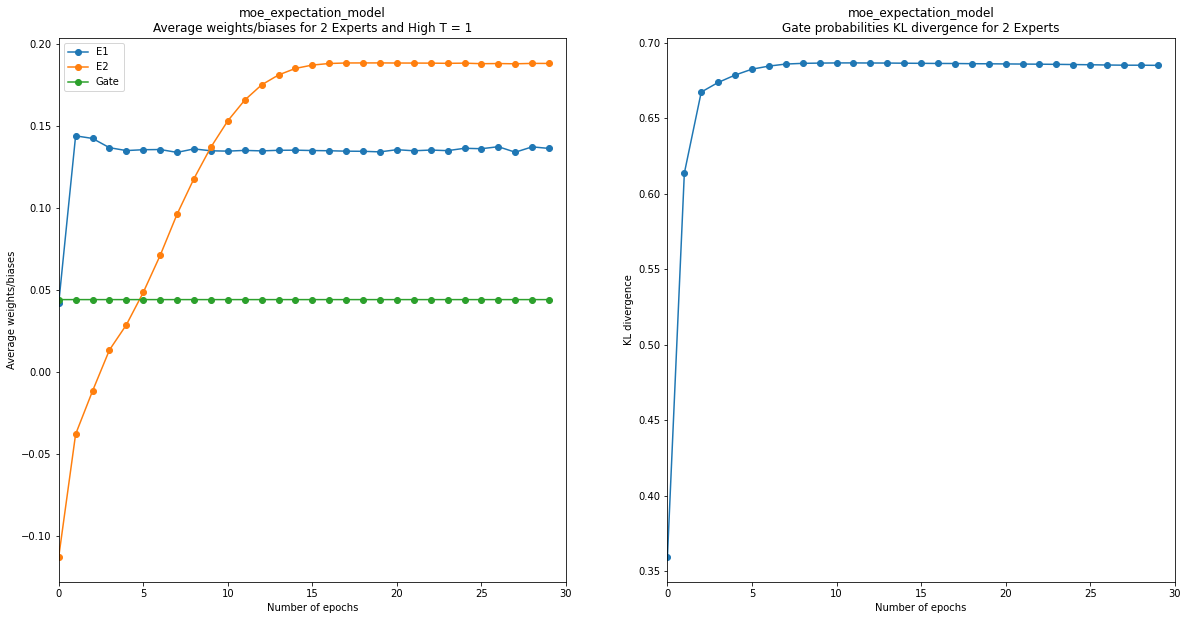

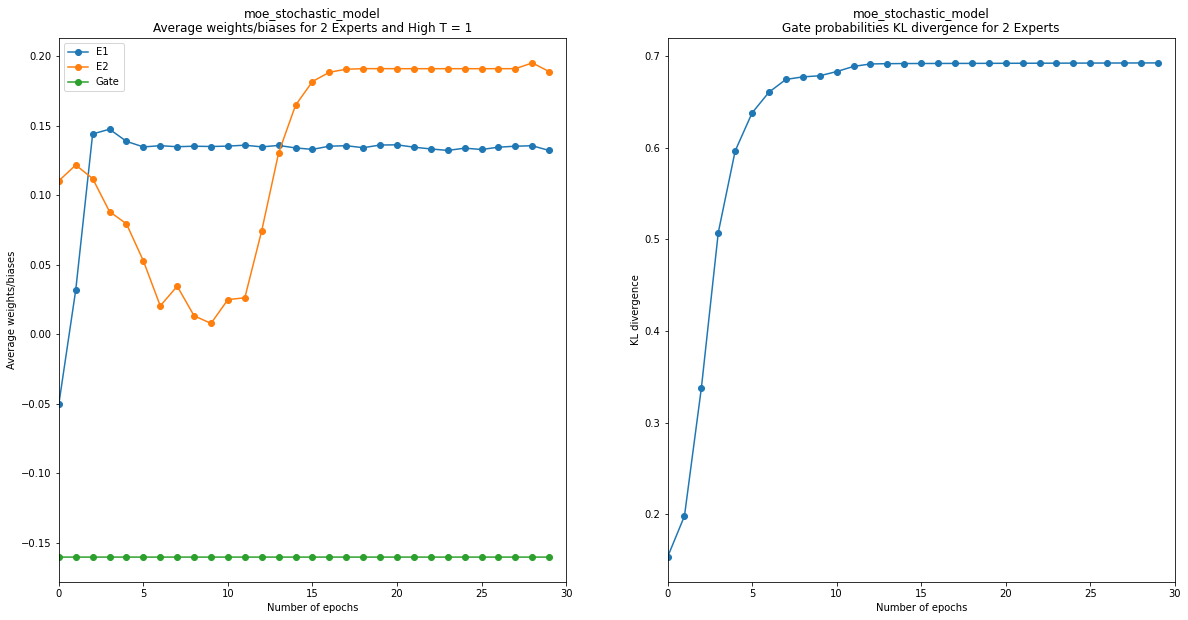

In [33]:
plt.rcParams["figure.figsize"] = (8,4)
for T in range(1, T_max+1):
    plot_file = generate_plot_file(dataset,'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
    print('model: ', plot_file)
    models = torch.load(os.path.join(model_path, plot_file))
    
    for m_key, m_val in models.items():
        
        fig,ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(20,10))

               
        for i in range(total_experts, total_experts+1):

            legend_labels = ['E'+str(j) for j in range(1, i+1)]
            
            history = m_val['experts'][i]['history']
            
            ax[0].plot(range(num_epochs), history['per_exp_avg_wts'], marker='o')
            ax[0].plot(range(num_epochs), history['gate_avg_wts'], marker='o')
            
            ax[0].set_title(m_key+'\n'+'Average weights/biases for ' + str(i) + ' Experts and High T = ' + str(T))
            ax[0].legend(legend_labels + ['Gate'])
            ax[0].set_xlabel('Number of epochs')
            ax[0].set_xlim(0, num_epochs)
            ax[0].set_ylabel('Average weights/biases')
            
                                    
            ax[1].plot(range(num_epochs), history['kl_div_gate'], marker='o')

            ax[1].set_title(m_key+'\n'+'Gate probabilities KL divergence for ' + str(i) + ' Experts')
            ax[1].set_xlabel('Number of epochs')
            ax[1].set_xlim(0, num_epochs)
            ax[1].set_ylabel('KL divergence')

            image_file = generate_plot_file(dataset+'_'+m_key,'T_'+str(T)+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
            plt.savefig(os.path.join(fig_path, 'dashboard_misc_'+image_file))
            plt.show()
            